# Projeto 1 - FGV QUANT
## Otimização de Portfólio (Markowitz) e Tomada de Decisão

- A escolha será baseada no Índice Brasil 50 (IBrX 50 B3) data: 20/05/21

- Comparar EW x CW x GMV x MSR \
  . EW = EqualWeighted \
  . CW =  CapWeighted \
  . GMV = Global Minimum Variance \
  . MSR = Maximum Sharpe Ratio

- Parâmetros da Otimização \
  . Risk free = SELIC 10 anos \
  . Apenas Long
 
- Fazer uma Análise de Fatores de Risco (CAPM e o Fama-French)

- Backtest
- Colocar aportes mensais
- Não mudar os pesos

Referências:
https://github.com/HugoAzv/Investment-Management/blob/main/2.%20Advanced%20Portfolio%20Construction%20and%20Analysis%20with%20Python/Module%201%20Lab%20Session%20-%20Foundations.ipynb

https://github.com/HugoAzv/Investment-Management/blob/main/2.%20Advanced%20Portfolio%20Construction%20and%20Analysis%20with%20Python/Module%202%20Lab%20Session%20-%20Covariance%20Estimation.ipynb

# 1 - Importando as Bibliotecas

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data
from selenium import webdriver
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

# 2 - Coletando os dados

In [37]:
inicio = '01-01-2015'
fim = '01-01-2020'

In [38]:
ibovespa = ['^BVSP']
tickers = ['ELET3.SA', 'TRPL4.SA', 'TAEE11.SA', 'VIVT3.SA', 'CYRE3.SA', 'BBAS3.SA', 'SANB11.SA', 'BBSE3.SA'] + ibovespa
tickers

['ELET3.SA',
 'TRPL4.SA',
 'TAEE11.SA',
 'VIVT3.SA',
 'CYRE3.SA',
 'BBAS3.SA',
 'SANB11.SA',
 'BBSE3.SA',
 '^BVSP']

In [39]:
''' para comentar em bloco: ctrl + / (do teclado numérico)'''
# DataFrame para carregar os preços dos tickers
prices = pd.DataFrame()

# for ticker in tickers:
#     if ticker != '^BVSP':
#         prices[ticker] = data.DataReader(ticker+'.SA', data_source='yahoo', start=inicio, end=fim)['Adj Close']
#     else:
#         prices[ticker] = data.DataReader(ticker, data_source='yahoo', start=inicio, end=fim)['Adj Close']

for ticker in tickers:
    prices[ticker] = data.DataReader(ticker, data_source='yahoo', start=inicio, end=fim)['Adj Close']
        
# Ajustar o Índice e a coluna do IBOV
prices.index.name = 'Date'
prices = prices.rename(columns = {'^BVSP':'IBOV'})

# Salvar o DataFrame para futuras aplicações
prices.to_csv('carteira_2015_a_2020.csv')

In [40]:
carteira = pd.read_csv('carteira_2015_a_2020.csv', header=0, index_col=0, na_values=-99.99)
prices = carteira.iloc[:,:-1]
prices

,ELET3.SA,TRPL4.SA,TAEE11.SA,VIVT3.SA,CYRE3.SA,BBAS3.SA,SANB11.SA,BBSE3.SA
Date,,,,,,,,
2015-01-02,4.591455,6.112401,9.385139,23.768299,7.681489,15.901145,8.792006,18.853855
2015-01-05,4.502222,6.119913,9.350287,23.296963,7.879957,15.571194,8.729797,18.288551
2015-01-06,4.542781,6.085372,9.365224,22.718771,8.100478,15.788818,8.792006,19.065069
2015-01-07,4.705024,6.259582,9.380158,23.498070,8.313648,16.483839,9.158340,18.760674
2015-01-08,4.615792,6.300130,9.469777,24.453323,8.379807,16.539999,9.006276,18.704763
...,...,...,...,...,...,...,...,...
2019-12-20,29.977453,19.421001,25.321644,42.576336,25.819460,47.502693,42.960587,32.934811
2019-12-23,32.077042,19.760500,25.455311,42.707077,25.881399,48.935398,42.915142,33.118073
2019-12-26,31.577141,19.986828,25.831253,43.482777,26.545025,49.493603,43.669632,32.952259


In [41]:
ibov = portfolio[['IBOV']]
ibov

,IBOV
Date,
2015-01-02,48512.0
2015-01-05,47517.0
2015-01-06,48001.0
2015-01-07,49463.0
2015-01-08,49943.0
...,...
2021-05-28,125561.0
2021-05-31,126216.0
2021-06-01,128267.0


# 3 - Análise Exploratória

In [42]:
retornos = prices.pct_change().dropna()
retornos

,ELET3.SA,TRPL4.SA,TAEE11.SA,VIVT3.SA,CYRE3.SA,BBAS3.SA,SANB11.SA,BBSE3.SA
Date,,,,,,,,
2015-01-05,-0.019435,0.001229,-0.003713,-0.019830,0.025837,-0.020750,-0.007076,-0.029983
2015-01-06,0.009009,-0.005644,0.001597,-0.024818,0.027985,0.013976,0.007126,0.042459
2015-01-07,0.035714,0.028628,0.001595,0.034302,0.026316,0.044020,0.041667,-0.015966
2015-01-08,-0.018965,0.006478,0.009554,0.040652,0.007958,0.003407,-0.016604,-0.002980
2015-01-09,-0.021090,-0.082718,-0.006835,-0.015934,-0.053509,-0.043294,-0.009977,-0.032547
...,...,...,...,...,...,...,...,...
2019-12-20,0.003067,-0.006236,-0.011093,0.020899,-0.003755,-0.001955,0.009613,-0.014621
2019-12-23,0.070039,0.017481,0.005279,0.003071,0.002399,0.030160,-0.001058,0.005564
2019-12-26,-0.015584,0.011454,0.014769,0.018163,0.025641,0.011407,0.017581,-0.005007


In [43]:
retornos.describe()

,ELET3.SA,TRPL4.SA,TAEE11.SA,VIVT3.SA,CYRE3.SA,BBAS3.SA,SANB11.SA,BBSE3.SA
count,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000
mean,0.002202,0.001057,0.000945,0.000644,0.001249,0.001292,0.001545,0.000641
std,0.036853,0.015148,0.015783,0.018497,0.022671,0.027561,0.021508,0.019611
min,-0.209698,-0.082718,-0.083085,-0.102649,-0.162632,-0.211712,-0.111470,-0.102251
25%,-0.017886,-0.007631,-0.008709,-0.009338,-0.011912,-0.013858,-0.011557,-0.010685
50%,0.000000,0.000819,0.000485,0.000000,0.000000,0.000216,0.000863,0.000102
75%,0.018778,0.009856,0.010576,0.011045,0.014981,0.015875,0.014421,0.011288
max,0.492958,0.102339,0.087322,0.091172,0.116764,0.143725,0.088235,0.109071


In [44]:
retornos.isnull().sum()

ELET3.SA     0
TRPL4.SA     0
TAEE11.SA    0
VIVT3.SA     0
CYRE3.SA     0
BBAS3.SA     0
SANB11.SA    0
BBSE3.SA     0
dtype: int64

<Figure size 432x288 with 0 Axes>

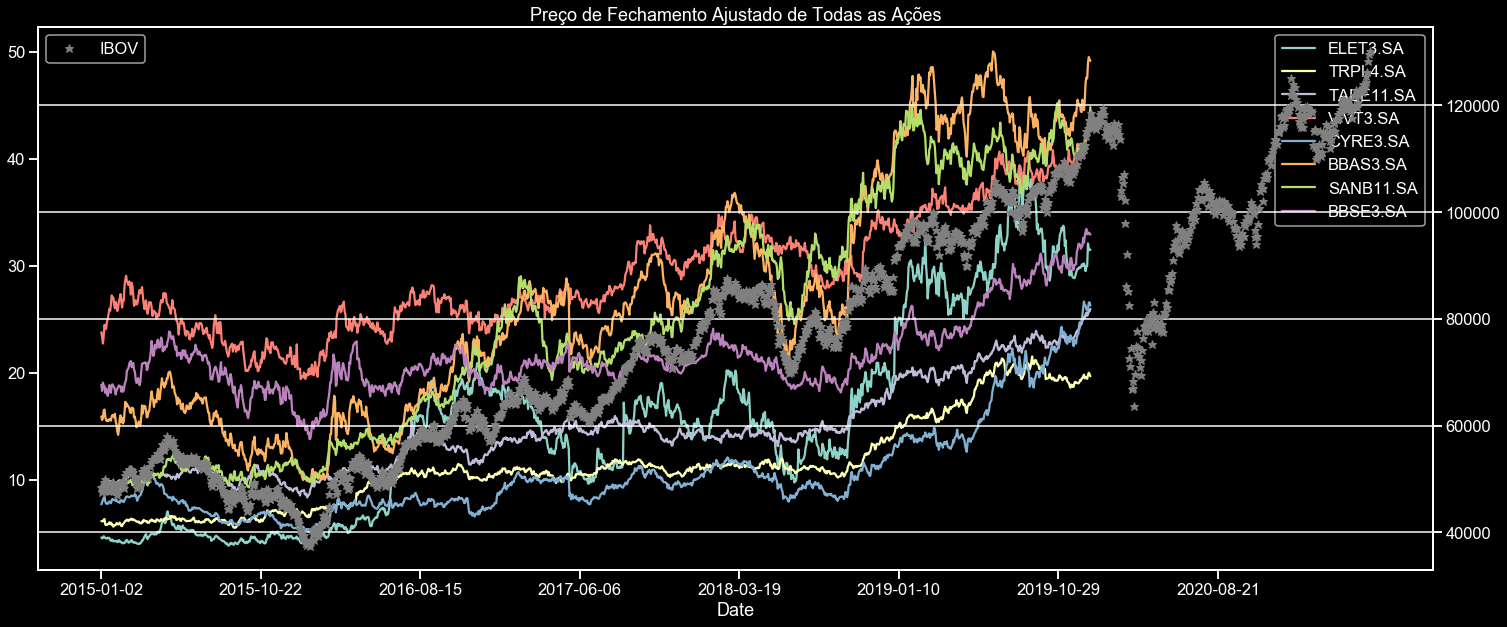

In [45]:
fig = plt.figure()
ax1 = prices.plot(figsize=(25,10), title='Preço de Fechamento Ajustado de Todas as Ações')
ax2 = ax1.twinx()
ibov.plot(ax=ax2, color='grey', style='*');
plt.legend()
plt.grid()

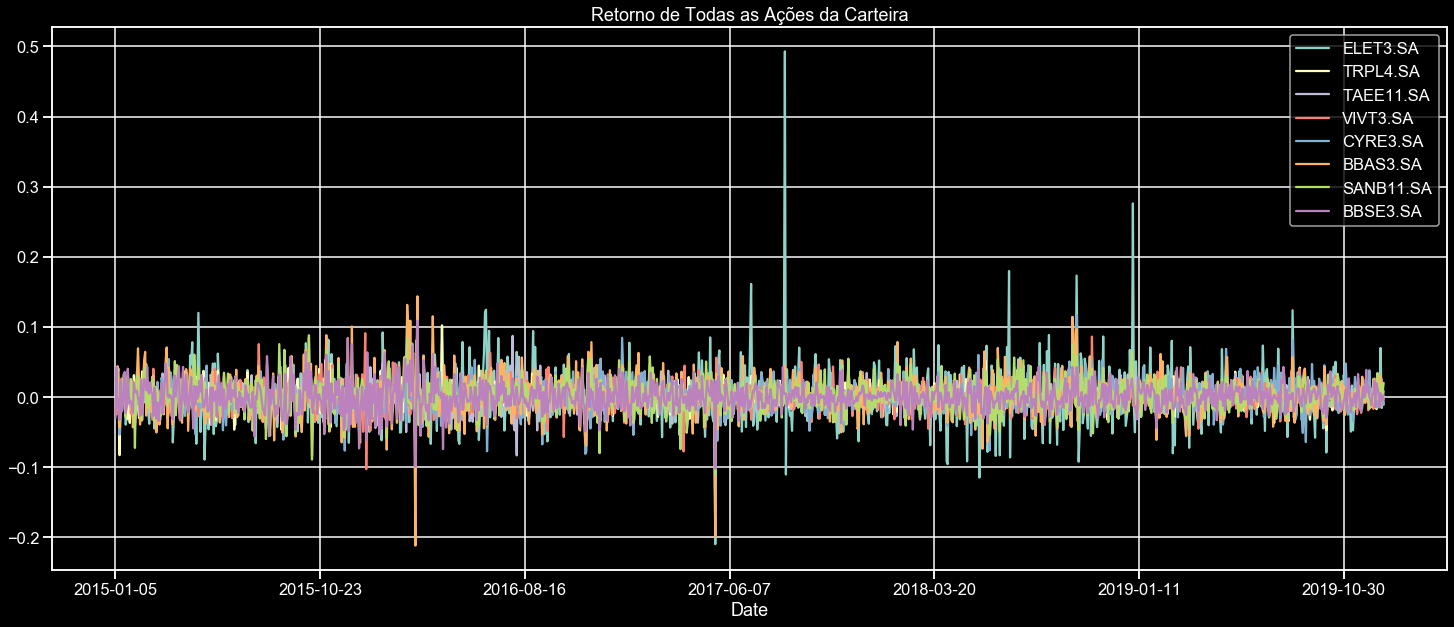

In [46]:
retornos.plot(figsize=(25,10), title='Retorno de Todas as Ações da Carteira');
plt.legend()
plt.grid()

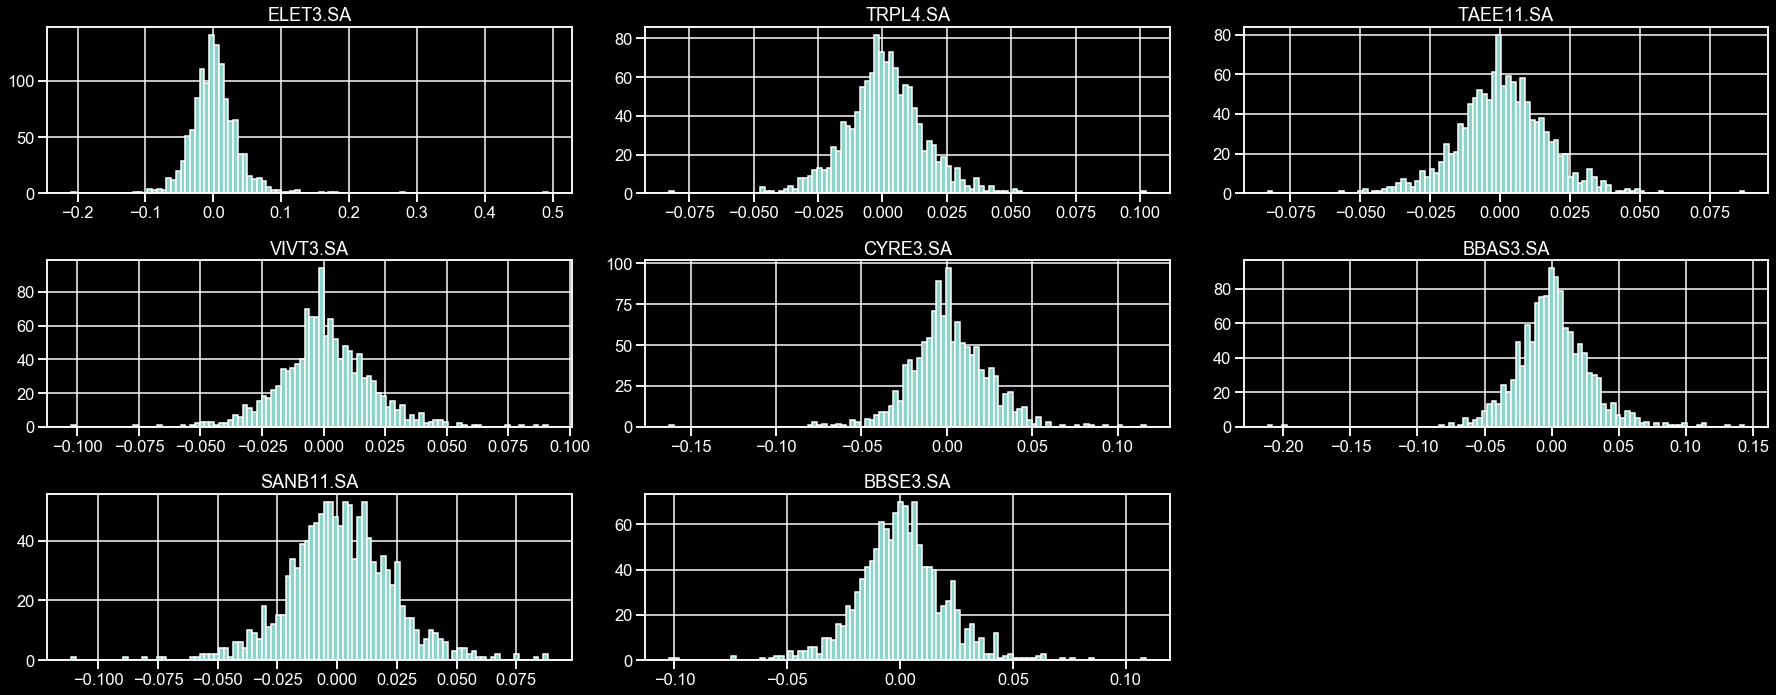

In [47]:
retornos.hist(bins=100, figsize=(25,10));
plt.tight_layout()

# 4 - Correlação dos ativos com o ibovespa

In [54]:
corr_carteira = carteira.pct_change().dropna()
corr_carteira

,ELET3.SA,TRPL4.SA,TAEE11.SA,VIVT3.SA,CYRE3.SA,BBAS3.SA,SANB11.SA,BBSE3.SA,IBOV
Date,,,,,,,,,
2015-01-05,-0.019435,0.001229,-0.003713,-0.019830,0.025837,-0.020750,-0.007076,-0.029983,-0.020510
2015-01-06,0.009009,-0.005644,0.001597,-0.024818,0.027985,0.013976,0.007126,0.042459,0.010186
2015-01-07,0.035714,0.028628,0.001595,0.034302,0.026316,0.044020,0.041667,-0.015966,0.030458
2015-01-08,-0.018965,0.006478,0.009554,0.040652,0.007958,0.003407,-0.016604,-0.002980,0.009704
2015-01-09,-0.021090,-0.082718,-0.006835,-0.015934,-0.053509,-0.043294,-0.009977,-0.032547,-0.022085
...,...,...,...,...,...,...,...,...,...
2019-12-20,0.003067,-0.006236,-0.011093,0.020899,-0.003755,-0.001955,0.009613,-0.014621,-0.000087
2019-12-23,0.070039,0.017481,0.005279,0.003071,0.002399,0.030160,-0.001058,0.005564,0.006445
2019-12-26,-0.015584,0.011454,0.014769,0.018163,0.025641,0.011407,0.017581,-0.005007,0.011565


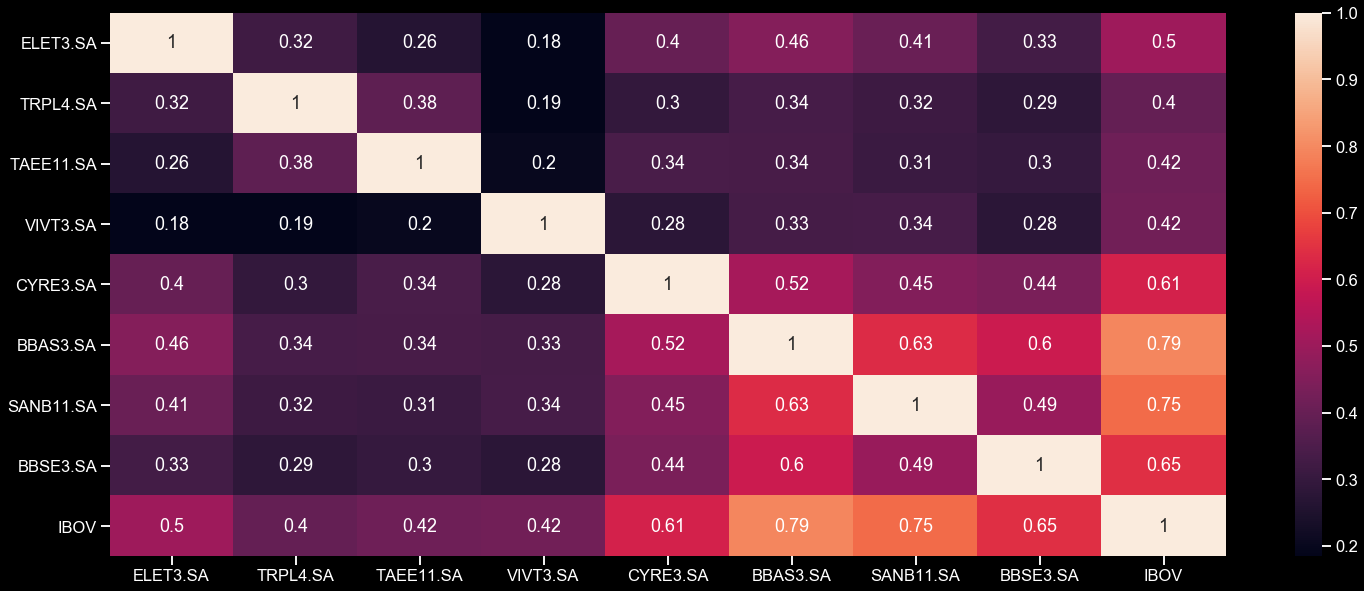

In [55]:
plt.figure(figsize = (25,10))
ax = sns.heatmap(corr_carteira.corr(), annot = True)

<Figure size 1800x720 with 0 Axes>

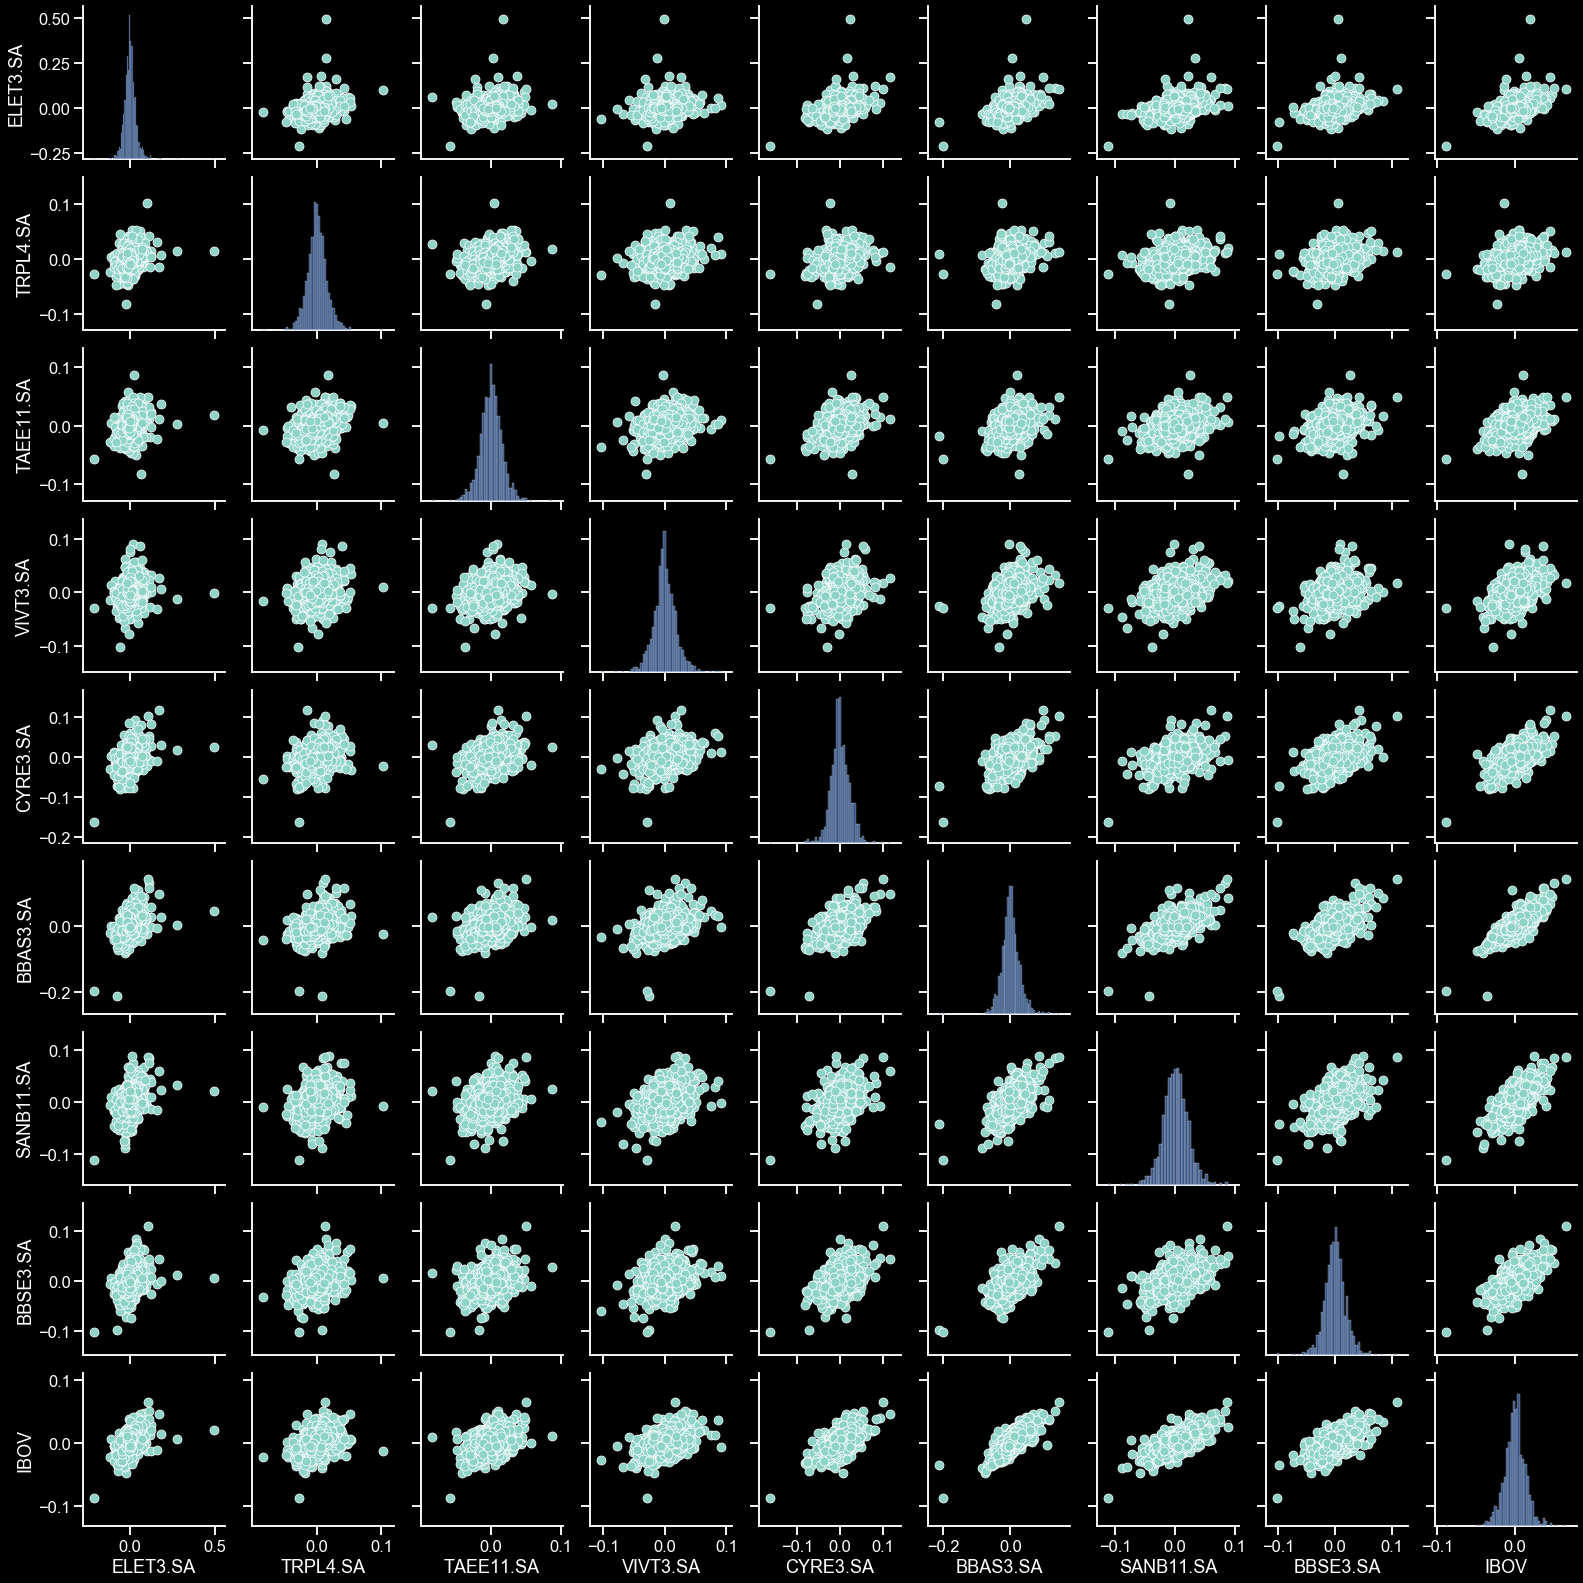

In [56]:
plt.figure(figsize = (25,10))
ax = sns.pairplot(corr_carteira)

## Retorno do Ibovespa no período

In [59]:
# ibov = data.DataReader('^BVSP', data_source='yahoo', start=inicio, end=fim)['Adj Close']
ibov_retornos = ibov.pct_change().dropna()
ibov_retornos.head(5)

,IBOV
Date,
2015-01-05,-0.020510
2015-01-06,0.010186
2015-01-07,0.030458
2015-01-08,0.009704
2015-01-09,-0.022085


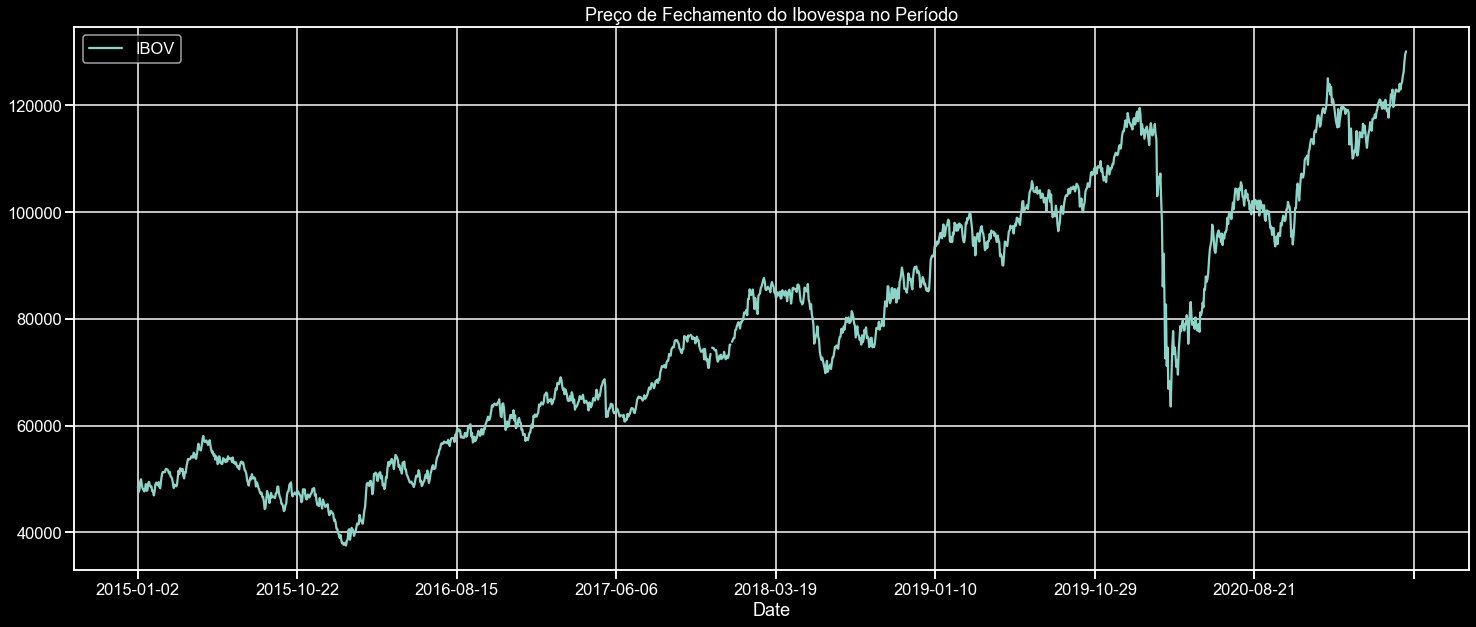

In [74]:
ibov.plot(figsize=(25,10), title='Preço de Fechamento do Ibovespa no Período');
plt.legend()
plt.grid()

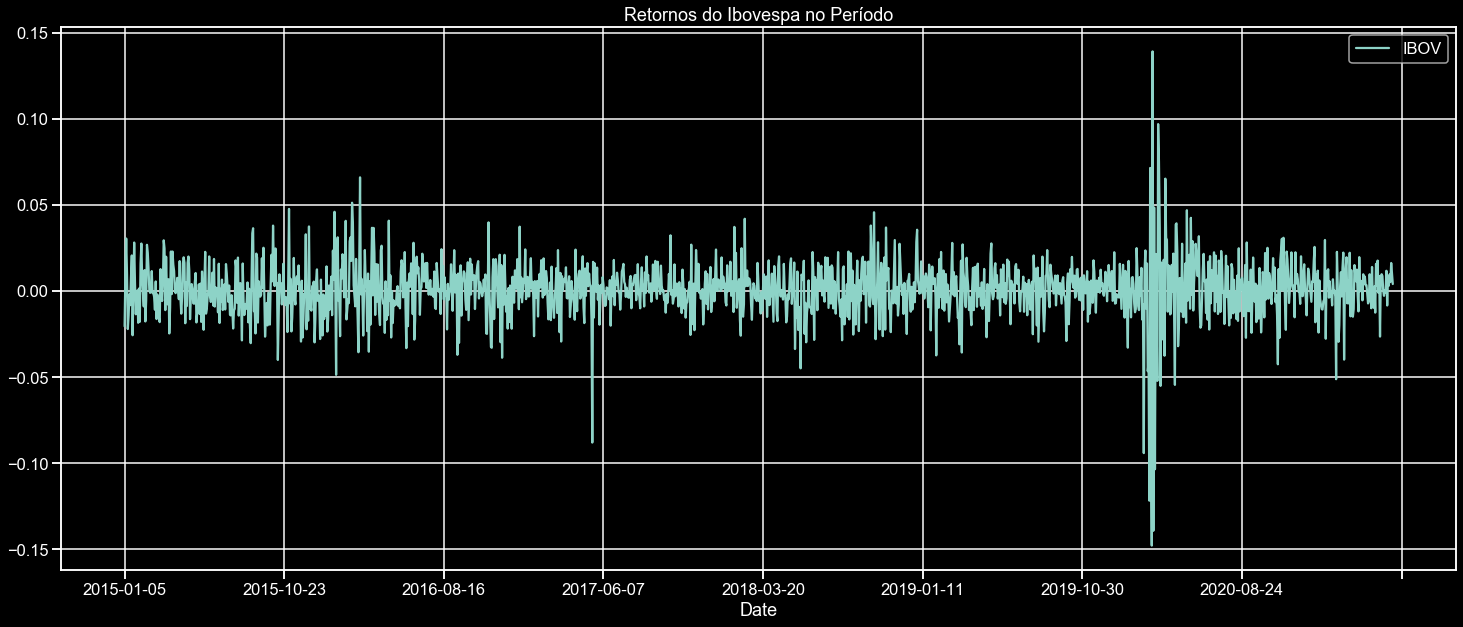

In [75]:
ibov_retornos.plot(figsize=(25,10), title='Retornos do Ibovespa no Período');
plt.legend()
plt.grid()

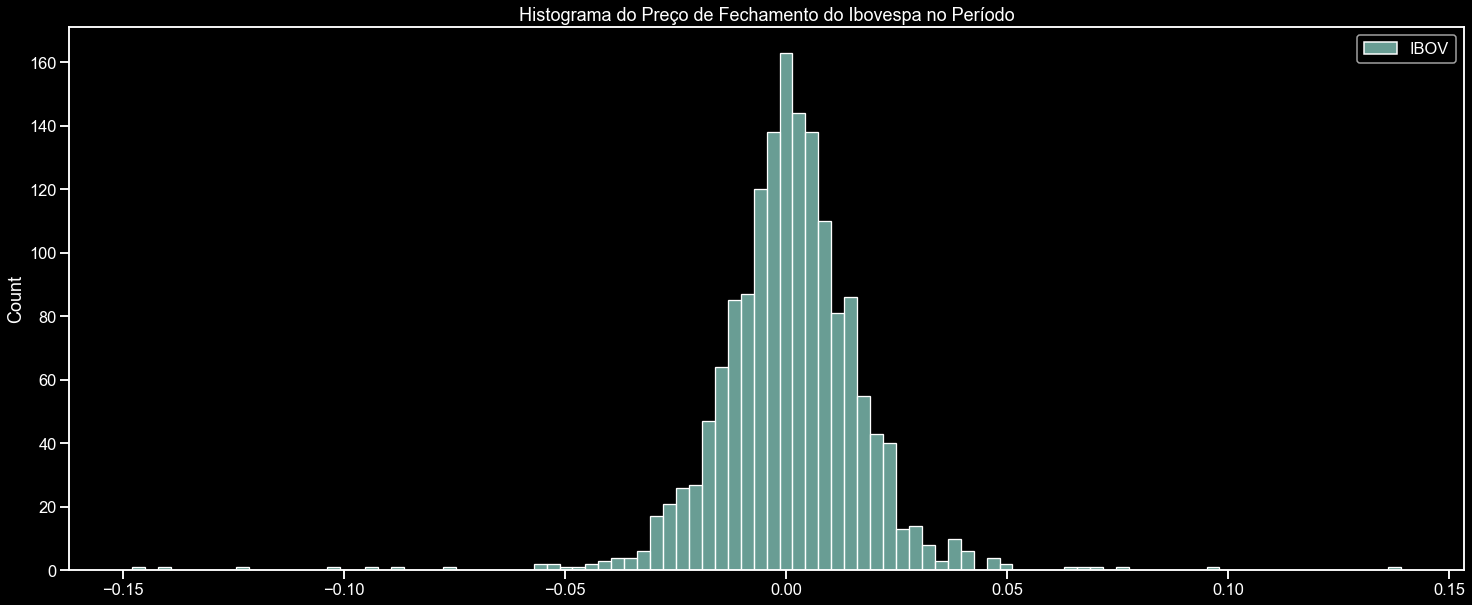

In [80]:
plt.figure(figsize = (25,10))
ax = sns.histplot(ibov_retornos)
plt.title('Histograma do Preço de Fechamento do Ibovespa no Período');

# 5 - Retornos Acumulados

In [63]:
soma_retornos = (retornos + 1).cumprod()
soma_ibov_retornos = (ibov_retornos+1).cumprod()

In [72]:
soma_retornos.tail(5)

,ELET3.SA,TRPL4.SA,TAEE11.SA,VIVT3.SA,CYRE3.SA,BBAS3.SA,SANB11.SA,BBSE3.SA
Date,,,,,,,,
2019-12-20,6.528966,3.177311,2.698058,1.791308,3.361257,2.987376,4.886324,1.746848
2019-12-23,6.986248,3.232854,2.712300,1.796808,3.369321,3.077476,4.881155,1.756568
2019-12-26,6.877371,3.269881,2.752357,1.829444,3.455714,3.112581,4.966970,1.747773
2019-12-27,6.848338,3.247095,2.741675,1.808909,3.458017,3.099124,4.994886,1.751476
2019-12-30,6.859225,3.215764,2.764819,1.798275,3.420004,3.090348,5.097245,1.744996


In [73]:
soma_ibov_retornos.tail(5)

,IBOV
Date,
2021-05-28,2.588246
2021-05-31,2.601748
2021-06-01,2.644026
2021-06-02,2.671525
2021-06-04,2.682347


<Figure size 432x288 with 0 Axes>

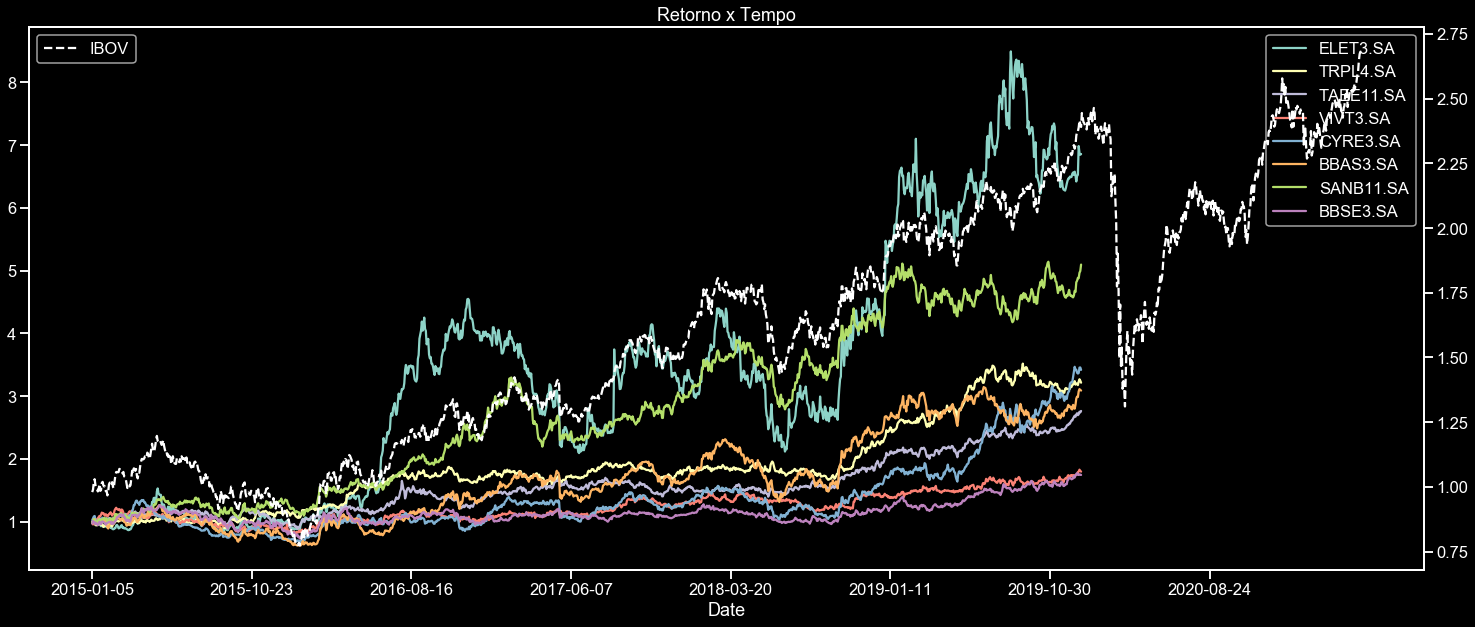

In [71]:
fig = plt.figure();
ax1 = soma_retornos.plot(title='Retorno x Tempo', figsize = (25,10));

ax2 = ax1.twinx();
soma_ibov_retornos.plot(ax=ax2, color='white', style='--');

# 6 - Ajuste ao Risco

In [85]:
vol = retornos.std()
vol_anualizada = vol*np.sqrt(12)

In [86]:
vol

ELET3.SA     0.036853
TRPL4.SA     0.015148
TAEE11.SA    0.015783
VIVT3.SA     0.018497
CYRE3.SA     0.022671
BBAS3.SA     0.027561
SANB11.SA    0.021508
BBSE3.SA     0.019611
dtype: float64

In [87]:
vol_anualizada

ELET3.SA     0.127664
TRPL4.SA     0.052473
TAEE11.SA    0.054672
VIVT3.SA     0.064075
CYRE3.SA     0.078534
BBAS3.SA     0.095476
SANB11.SA    0.074505
BBSE3.SA     0.067933
dtype: float64

In [88]:
num_dias = retornos.shape[0]
retornos_anualizado = (retornos+1).prod()**(252/num_dias) - 1
retornos_anualizado

ELET3.SA     0.478947
TRPL4.SA     0.267924
TAEE11.SA    0.229584
VIVT3.SA     0.126661
CYRE3.SA     0.283891
BBAS3.SA     0.257715
SANB11.SA    0.392351
BBSE3.SA     0.119796
dtype: float64

In [91]:
retornos_anualizado/vol_anualizada

ELET3.SA     3.751636
TRPL4.SA     5.105903
TAEE11.SA    4.199272
VIVT3.SA     1.976766
CYRE3.SA     3.614870
BBAS3.SA     2.699276
SANB11.SA    5.266129
BBSE3.SA     1.763434
dtype: float64

In [92]:
retorno_livre_de_risco = 0.13
excess_return = retornos_anualizado - retorno_livre_de_risco
sharpe_ratio = excess_return/vol_anualizada
sharpe_ratio

ELET3.SA     2.733334
TRPL4.SA     2.628456
TAEE11.SA    1.821466
VIVT3.SA    -0.052107
CYRE3.SA     1.959538
BBAS3.SA     1.337670
SANB11.SA    3.521273
BBSE3.SA    -0.150208
dtype: float64

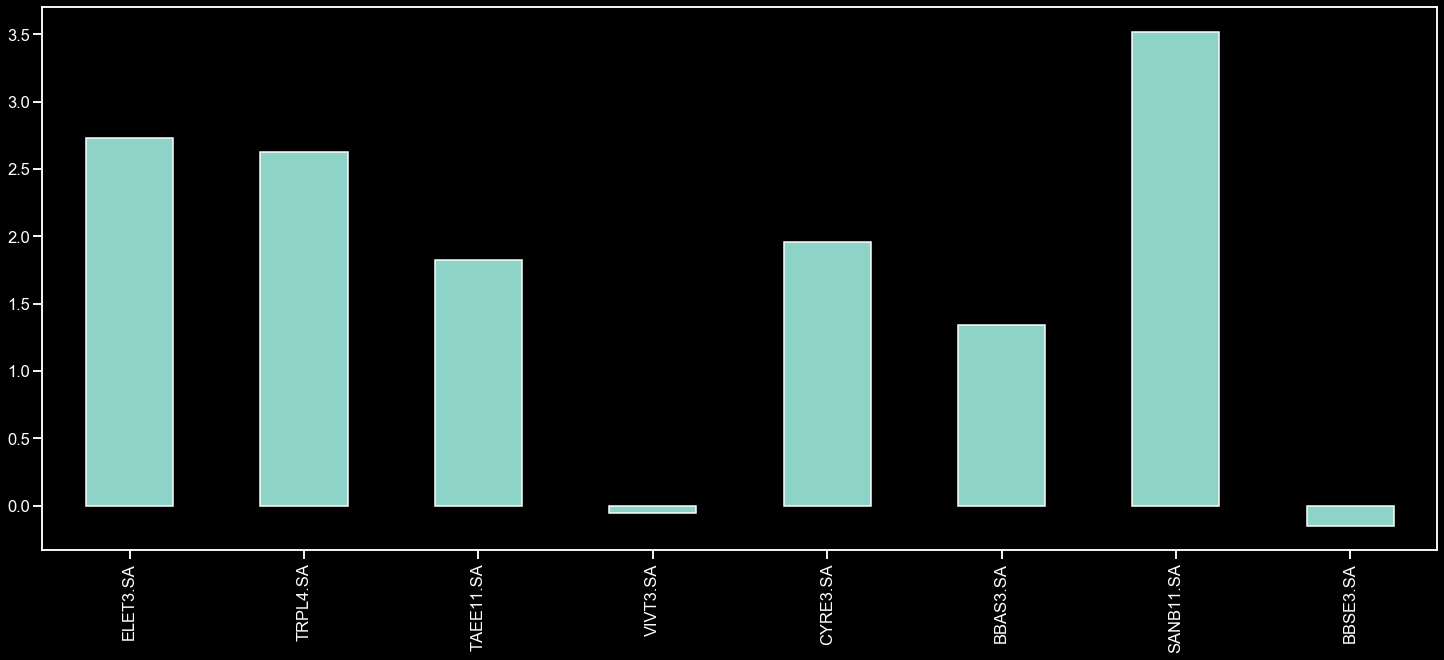

In [125]:
sharpe_ratio.plot.bar(figsize=(25,10));

# 7 - Calcular Drawdowns

# 8 - Testar Normalidade

In [94]:
import scipy.stats as ss

## Skewness

In [98]:
def skewness(r):
    demeaned_r = r - r.mean()
    # usar o std da população, ddof = 0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3

In [102]:
S = skewness(retornos)
S

ELET3.SA     2.429685
TRPL4.SA     0.189034
TAEE11.SA   -0.010214
VIVT3.SA     0.123487
CYRE3.SA    -0.102058
BBAS3.SA    -0.125299
SANB11.SA   -0.019360
BBSE3.SA     0.072920
dtype: float64

## Kurtosis

In [103]:
def kurtosis(r):
    demeaned_r = r - r.mean()
    # usar o std da população, ddof = 0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

In [105]:
K = kurtosis(retornos)
K

ELET3.SA     32.096378
TRPL4.SA      5.567390
TAEE11.SA     4.634377
VIVT3.SA      5.403803
CYRE3.SA      6.604482
BBAS3.SA      9.460043
SANB11.SA     4.641706
BBSE3.SA      5.631774
dtype: float64

## Jarque Berat

In [106]:
def is_normal(r, level=0.01):
    if isinstance(r, pd.DataFrame):
        return r.aggregate(is_normal)
    else:
        statistic, p_value = ss.jarque_bera(r)
        return p_value > level

In [108]:
normality = is_normal(retornos)
normality

ELET3.SA     False
TRPL4.SA     False
TAEE11.SA    False
VIVT3.SA     False
CYRE3.SA     False
BBAS3.SA     False
SANB11.SA    False
BBSE3.SA     False
dtype: bool

# 9 - Medidas de Risco

## Semideviation

In [109]:
def semideviation(r):
    if isinstance(r, pd.Series):
        is_negative = r < 0
        return r[is_negative].std(ddof=0)
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(semideviation)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [110]:
semi_dev = semideviation(retornos)
semi_dev

ELET3.SA     0.020591
TRPL4.SA     0.009492
TAEE11.SA    0.010132
VIVT3.SA     0.011998
CYRE3.SA     0.014882
BBAS3.SA     0.018373
SANB11.SA    0.013666
BBSE3.SA     0.012723
dtype: float64

## Var and CVaR
Value at Risk

- Historic VaR
- Parametric VaR - Gaussian
- Modified Cornish-Fisher VaR

### Historic VaR

In [114]:
def var_historic(r, level=5):
    """
    VaR Historic
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be Series or DataFrame")

In [115]:
var_historic(retornos)

ELET3.SA     0.048230
TRPL4.SA     0.023654
TAEE11.SA    0.024676
VIVT3.SA     0.028998
CYRE3.SA     0.031481
BBAS3.SA     0.039474
SANB11.SA    0.032177
BBSE3.SA     0.029281
dtype: float64

### Parametric VaR - Gaussian

In [111]:
def var_gaussian(r, S, K, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = ss.norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = S
        k = K
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

In [113]:
var_gaussian(retornos, S, K)

ELET3.SA     0.058392
TRPL4.SA     0.023849
TAEE11.SA    0.025005
VIVT3.SA     0.029768
CYRE3.SA     0.036026
BBAS3.SA     0.044025
SANB11.SA    0.033817
BBSE3.SA     0.031603
dtype: float64

### Modified Cornish-Fisher VaR

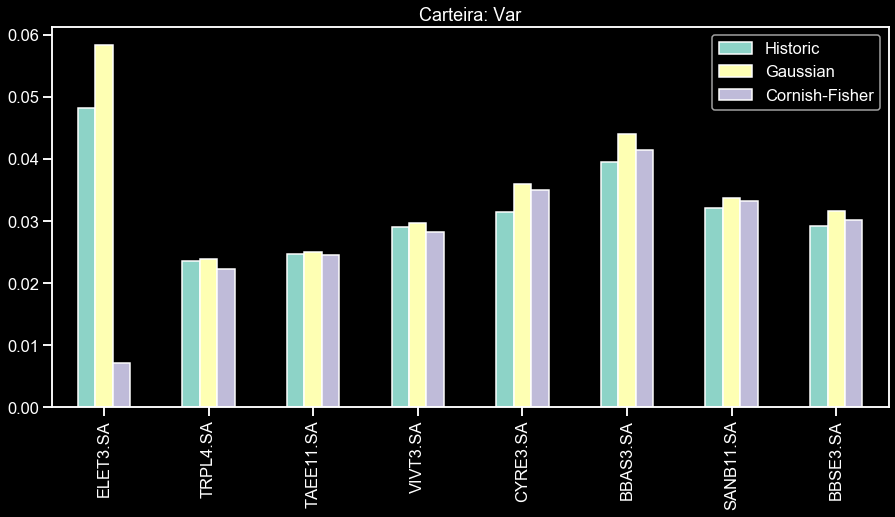

In [132]:
var_list = [var_historic(retornos), var_gaussian(retornos, S, K), var_gaussian(retornos, S, K, modified=True)]
comparação = pd.concat(var_list, axis = 1)
comparação.columns = ["Historic", "Gaussian", "Cornish-Fisher"]
comparação.plot.bar(figsize=(15,7), title = "Carteira: Var");

### BeyondVar aka CVar

In [123]:
def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [124]:
cvar_historic(retornos)

ELET3.SA     0.067474
TRPL4.SA     0.031302
TAEE11.SA    0.033870
VIVT3.SA     0.039458
CYRE3.SA     0.048034
BBAS3.SA     0.055943
SANB11.SA    0.045531
BBSE3.SA     0.042291
dtype: float64

# 10 - Analisando o Portfolio via Markowitz

In [127]:
carteira.head(5)

,ELET3.SA,TRPL4.SA,TAEE11.SA,VIVT3.SA,CYRE3.SA,BBAS3.SA,SANB11.SA,BBSE3.SA,IBOV
Date,,,,,,,,,
2015-01-02,4.591455,6.112401,9.385139,23.768299,7.681489,15.901145,8.792006,18.853855,48512.0
2015-01-05,4.502222,6.119913,9.350287,23.296963,7.879957,15.571194,8.729797,18.288551,47517.0
2015-01-06,4.542781,6.085372,9.365224,22.718771,8.100478,15.788818,8.792006,19.065069,48001.0
2015-01-07,4.705024,6.259582,9.380158,23.498070,8.313648,16.483839,9.158340,18.760674,49463.0
2015-01-08,4.615792,6.300130,9.469777,24.453323,8.379807,16.539999,9.006276,18.704763,49943.0


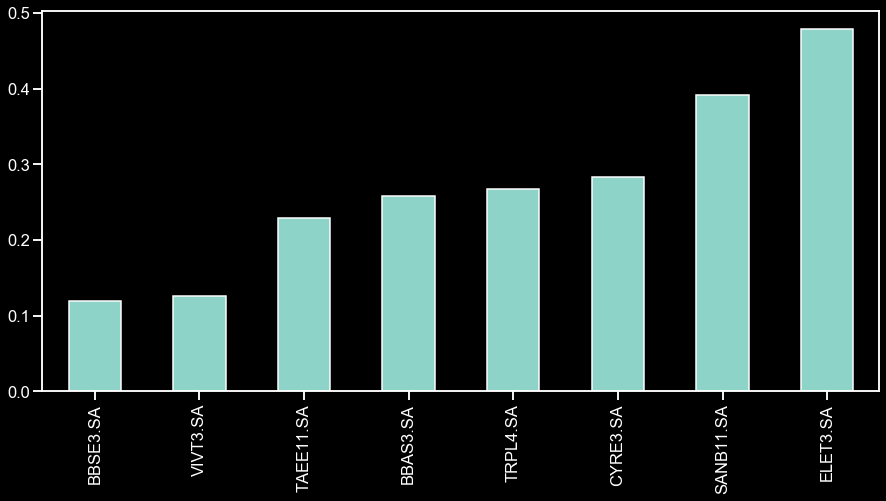

In [131]:
retornos_anualizado.sort_values().plot.bar(figsize=(15,7));

In [140]:
cov = retornos.cov()
cov

,ELET3.SA,TRPL4.SA,TAEE11.SA,VIVT3.SA,CYRE3.SA,BBAS3.SA,SANB11.SA,BBSE3.SA
ELET3.SA,0.001358,0.000179,0.000154,0.000126,0.000333,0.000464,0.000322,0.000237
TRPL4.SA,0.000179,0.000229,0.000092,0.000052,0.000101,0.000140,0.000103,0.000085
TAEE11.SA,0.000154,0.000092,0.000249,0.000059,0.000122,0.000148,0.000105,0.000093
VIVT3.SA,0.000126,0.000052,0.000059,0.000342,0.000116,0.000170,0.000134,0.000101
CYRE3.SA,0.000333,0.000101,0.000122,0.000116,0.000514,0.000326,0.000221,0.000194
BBAS3.SA,0.000464,0.000140,0.000148,0.000170,0.000326,0.000760,0.000376,0.000322
SANB11.SA,0.000322,0.000103,0.000105,0.000134,0.000221,0.000376,0.000463,0.000209
BBSE3.SA,0.000237,0.000085,0.000093,0.000101,0.000194,0.000322,0.000209,0.000385


In [141]:
def portfolio_return(weights, returns):
    """
    Weights -> Returns
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Weights -> Vol
    """
    return (weights.T @ covmat @ weights)**0.5

## Portfolio com Pesos Iguais dos Ativoso = EW

In [145]:
weights = np.repeat(1/retornos.shape[1], retornos.shape[1])
weights

array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

In [146]:
portfolio_return(weights, retornos_anualizado)

0.26960856254929494

In [149]:
portfolio_vol(weights, cov)

0.015034374960762317

### Otimizando o Portfolio

In [155]:
from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    """
    target return -> W
    
    target_return = retorno desejado
    er = série de retornos anualizados
    cov = matriz de cov
    """
    
    n = er.shape[0] # Number of assets
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n # multiplying tuple, boundary condition to weights
    return_is_target = {
        'type': 'eq',
        'args': (er,),
        'fun': lambda weights, er: target_return - portfolio_return(weights, er)
    }
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights)-1
    }
    
    results = minimize(portfolio_vol, init_guess,
                       args=(cov,), method="SLSQP",
                       options={'disp': False},
                       constraints=(return_is_target, weights_sum_to_1),
                       bounds=bounds
                      )
    
    return results.x

###################################################################################################

def optimal_weights(n_points, er, cov):
    """
    -> list of weights to run the optimizer on to minimize the vol
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights
    
###################################################################################################
    
def plot_ef(n_points, er, cov, style=".-", figsize=(12,6)):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=style, figsize=figsize)

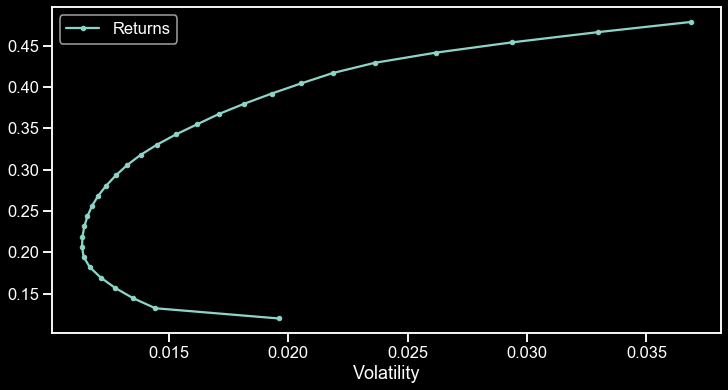

In [158]:
plot_ef(30, retornos_anualizado, cov);

In [160]:
weights_for_all_assets = optimal_weights(30, retornos_anualizado, cov)
weights_for_all_assets

[array([3.88578059e-16, 0.00000000e+00, 0.00000000e+00, 2.16768937e-07,
        2.16493490e-15, 7.04991621e-15, 0.00000000e+00, 9.99999783e-01]),
 array([0.00000000e+00, 0.00000000e+00, 8.48112720e-02, 4.47651667e-01,
        0.00000000e+00, 0.00000000e+00, 8.32667268e-17, 4.67537061e-01]),
 array([1.83366994e-18, 2.00414803e-02, 1.70893308e-01, 4.42563216e-01,
        0.00000000e+00, 0.00000000e+00, 3.87406563e-18, 3.66501995e-01]),
 array([0.00000000e+00, 8.91035922e-02, 1.93484413e-01, 3.95116293e-01,
        7.26954759e-18, 9.85412209e-18, 1.28704479e-18, 3.22295701e-01]),
 array([4.71515131e-18, 1.60993546e-01, 2.13127620e-01, 3.33796857e-01,
        0.00000000e+00, 0.00000000e+00, 4.72393146e-20, 2.92081976e-01]),
 array([7.56388851e-18, 2.21769646e-01, 2.45851471e-01, 3.03091946e-01,
        0.00000000e+00, 0.00000000e+00, 4.68943413e-19, 2.29286937e-01]),
 array([7.33467979e-18, 2.83884962e-01, 2.76747238e-01, 2.72725797e-01,
        0.00000000e+00, 1.16712557e-17, 0.00000000e+

## Achando o Portfólio com Maior Sharpe Ratio = MSR (Max Sharpe Ratio)

In [161]:
def msr(riskfree_rate, er, cov):
    """
    RiskFree rate + ER + COV  -> W
    
    RiskFree rate = RiskFree rate
    er = vector with expected returns of assets
    cov = covariance of assets
    """
    
    n = er.shape[0] # Number of assets
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n # multiplying tuple, boundary condition to weights
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights)-1
    }
    # If we want to maximize the sharpe ratio, we can minimize the negative sharpe ratio
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio, given weights
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r-riskfree_rate)/vol # negative of the sharpe ratio
        
    results = minimize(neg_sharpe_ratio, init_guess,
                       args=(riskfree_rate, er, cov,), method="SLSQP",
                       options={'disp': False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds
                      )
    
    return results.x

In [162]:
msr(retorno_livre_de_risco, retornos_anualizado, cov)

array([1.30283950e-01, 3.56628430e-01, 4.70619134e-02, 0.00000000e+00,
       1.09193368e-13, 0.00000000e+00, 4.66025706e-01, 0.00000000e+00])

## Achando o Portfólio com a Mínima Volatilidade = GMV (Global Minimum Vol)

In [165]:
def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

In [166]:
gmv(cov)

array([0.        , 0.34227025, 0.2814076 , 0.23239506, 0.01501252,
       0.        , 0.0113317 , 0.11758287])

## Plotando todos ao mesmo tempo

In [169]:
def plot_ef(n_points, er, cov, style='.-', legend=False, show_cml=False, riskfree_rate=0, show_ew=False, show_gmv=False, figsize=(12,6)):
    """
    Plots the multi-asset efficient frontier
    
    n_points = número de pontos para plotar o gráfico
    er = série de retornos anualizados
    cov = matriz de covariância
    show_cml = Mostrar o Capital Market Line?
    riskfree_rate = Retorno livre de risco, geralmente tomado como 12%
    show_ew = Destacar  o Portfólio EW?
    show_gmv = Destacar o Portfólio GMV?
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    ax = ef.plot.line(x="Volatility", y="Returns", style=style, legend=legend, figsize=figsize)
    if show_cml:
        ax.set_xlim(left = 0)
        # get MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10)
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        # add EW
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker='o', markersize=10)
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        # add EW
        ax.plot([vol_gmv], [r_gmv], color='midnightblue', marker='o', markersize=10)
        
        return ax

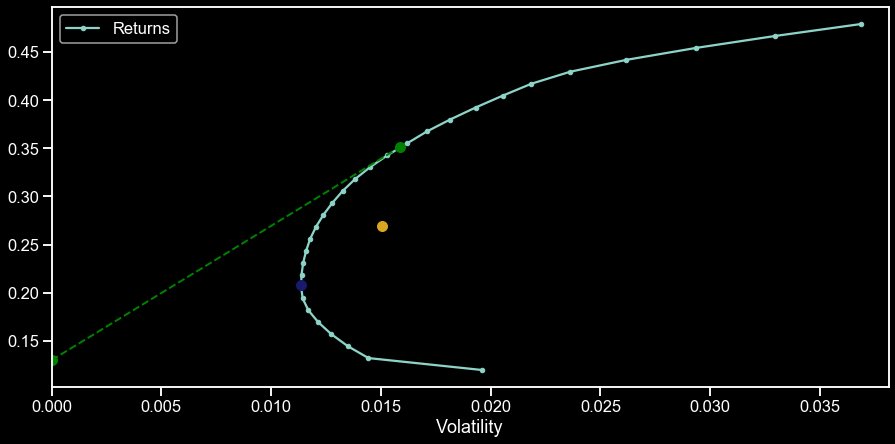

In [171]:
plot_ef(30, retornos_anualizado, cov, legend=True, show_cml=True, riskfree_rate=retorno_livre_de_risco, show_ew=True, show_gmv=True, figsize=(15,7));

In [172]:
# Continuar com gráficos desse site
# https://dataml.com.br/otimizando-uma-carteira-de-criptomoedas-usando-python/

O que fazer no dia 06 de Junho?

0. Calcular Drawdown da carteira
1. Fazer um código limpo que retorne todos os tipos de portfólios
2. Plotar portfólio com MSR
3. Adicionar informações desses portfólios em DataFrame (DataFrame do MSR = Retorno Esperado, Vol, Pesos)
4. Calcular Risk Contributions and Risk Parity
5. Gráfico de Pizza para os Pesos de cada tipo de portfólio

6. Fazer Backtesting dos portfólios
7. Testar backtesting com IBOV e CDI (pegar taxa de SELIC no Período)
